The Fama-French three-factor model is defined as:


$E(r_i) - r_f =\alpha + \beta_{mkt}(E(r_m)-r_f) + \beta_{smb}SMB + \beta_{hml}HML$

where
*   $E(r_i)$ denotes the expected return on asset $i$
*   $r_f$ is the risk-free rate
*   $E(r_m)$ denotes the expected return on the market
*   $\alpha$ is the intercept
*   $\beta$ is the coefficient
*   $SMB$ measures the excess return of stocks with a small market cap over those with a large market cap
*   $HML$ measures the excess return of value stocks over growth stocks

#  For Single Asset: NVDA

1.   Import the libraries

In [ ]:
!pip install --upgrade yfinance==0.2.54
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2.   Specify the risky asset and the time-line

In [ ]:
RISKY_ASSET = "NVDA"
START_DATE = "2021-12-31"
END_DATE = "2024-12-31"

3.   Download the dataset containing the risk factors

In [ ]:
ff_dict = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=START_DATE, end=END_DATE)

<ipython-input-3-a0c17bccecda>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_dict = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=START_DATE, end=END_DATE)
<ipython-input-3-a0c17bccecda>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_dict = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=START_DATE, end=END_DATE)


4.   Prepare the risk factor dataset

In [ ]:
factor_3 = ff_dict[0].rename(columns={"Mkt-RF": "MKT"}).div(100)
factor_3.head()

,MKT,SMB,HML,RF
Date,,,,
2021-12,0.0310,-0.0164,0.0322,0.0001
2022-01,-0.0625,-0.0596,0.1280,0.0000
2022-02,-0.0229,0.0219,0.0310,0.0000
2022-03,0.0306,-0.0166,-0.0176,0.0001
2022-04,-0.0946,-0.0138,0.0617,0.0001


*Plot historical time series of the risk factors*

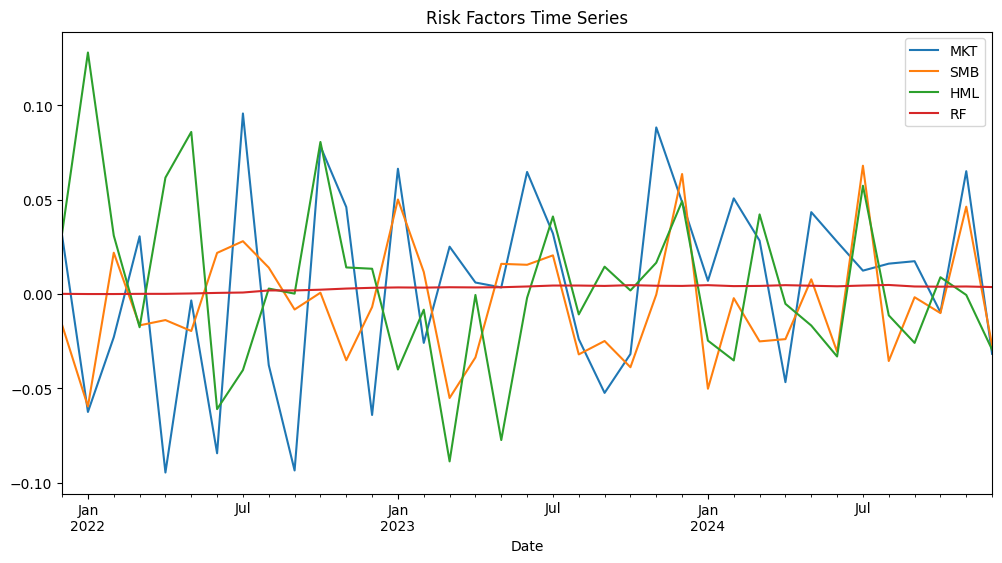

In [ ]:
factor_3[["MKT", "SMB", "HML", "RF"]].plot(figsize=(12, 6), title="Risk Factors Time Series")
plt.show()
# plt.savefig("Risk_Factors_Time_Series.png")

5.   Download the prices of the risky asset

In [ ]:
asset_df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
print(asset_df.shape)
print(asset_df.head())

(753, 5)
Price           Close       High        Low       Open     Volume
Ticker           NVDA       NVDA       NVDA       NVDA       NVDA
Date                                                             
2021-12-31  29.362165  29.980139  29.282298  29.624729  266530000
2022-01-03  30.070990  30.660010  29.735547  29.765498  391547000
2022-01-04  29.241369  30.417413  28.301932  30.226730  527154000
2022-01-05  27.558167  29.367158  27.487285  28.900933  498064000
2022-01-06  28.131214  28.390783  27.020063  27.594107  454186000


6.   Calculate the monthly returns on the risky asset

In [ ]:
target = asset_df["Close"].resample("M").last().pct_change().dropna()
target.index = target.index.to_period("M")
target.columns = ["RTN"]
print(target.head())

              RTN
Date             
2022-01 -0.167454
2022-02 -0.004125
2022-03  0.119157
2022-04 -0.320274
2022-05  0.006740


<ipython-input-7-bbb1e889676d>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  target = asset_df["Close"].resample("M").last().pct_change().dropna()


7.   Merge the risky asset with the risk factor dataset and calculate the excess return $E(r_i) - r_f$

In [ ]:
factor_3_df = factor_3.join(target)
factor_3_df["EX_RTN"] = factor_3_df["RTN"] - factor_3_df["RF"]
factor_3_df = factor_3_df.dropna()
print(factor_3_df.head())

            MKT     SMB     HML      RF       RTN    EX_RTN
Date                                                       
2022-01 -0.0625 -0.0596  0.1280  0.0000 -0.167454 -0.167454
2022-02 -0.0229  0.0219  0.0310  0.0000 -0.004125 -0.004125
2022-03  0.0306 -0.0166 -0.0176  0.0001  0.119157  0.119057
2022-04 -0.0946 -0.0138  0.0617  0.0001 -0.320274 -0.320374
2022-05 -0.0034 -0.0196  0.0859  0.0003  0.006740  0.006440


8.   Estimate the Fama-French 3-factor model

In [ ]:
ff3_model = smf.ols(formula="EX_RTN ~ MKT + SMB + HML", data=factor_3_df).fit()
print(ff3_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 EX_RTN   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     24.90
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           1.67e-08
Time:                        01:14:00   Log-Likelihood:                 36.679
No. Observations:                  36   AIC:                            -65.36
Df Residuals:                      32   BIC:                            -59.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0432      0.016      2.730      0.0

$E(r_i) - r_f =0.0432 + 2.3756(E(r_m)-r_f)  -0.6558SMB  -1.2024HML$

## Correlation among the three factors

In [ ]:
# Generate the correlation among the three factors
corr_matrix = factor_3_df.corr()
print(corr_matrix)

             MKT       SMB       HML        RF       RTN    EX_RTN
MKT     1.000000  0.314943 -0.128554  0.306689  0.756022  0.755784
SMB     0.314943  1.000000  0.002565  0.002016  0.107015  0.107393
HML    -0.128554  0.002565  1.000000 -0.283748 -0.433118 -0.431906
RF      0.306689  0.002016 -0.283748  1.000000  0.378239  0.369693
RTN     0.756022  0.107015 -0.433118  0.378239  1.000000  0.999958
EX_RTN  0.755784  0.107393 -0.431906  0.369693  0.999958  1.000000


## Re-run the model without the SMB factor (i.e. after dropping SMB factor considering its p-value)

In [ ]:
ff3_model_no_smb = smf.ols(formula="EX_RTN ~ MKT + HML", data=factor_3_df).fit()
print(ff3_model_no_smb.summary())

                            OLS Regression Results                            
Dep. Variable:                 EX_RTN   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     35.91
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           5.23e-09
Time:                        22:21:23   Log-Likelihood:                 35.803
No. Observations:                  36   AIC:                            -65.61
Df Residuals:                      33   BIC:                            -60.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0469      0.016      2.988      0.0

<ipython-input-14-b5da1651656b>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_extra_return = ff3_model.params[0] + ff3_model.params[1] * factor_3_df["MKT"] + ff3_model.params[2] * factor_3_df["SMB"] + ff3_model.params[3] * factor_3_df["HML"]
<ipython-input-14-b5da1651656b>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_extra_return_no_smb = ff3_model_no_smb.params[0] + ff3_model_no_smb.params[1] * factor_3_df["MKT"] + ff3_model_no_smb.params[2] * factor_3_df["HML"]


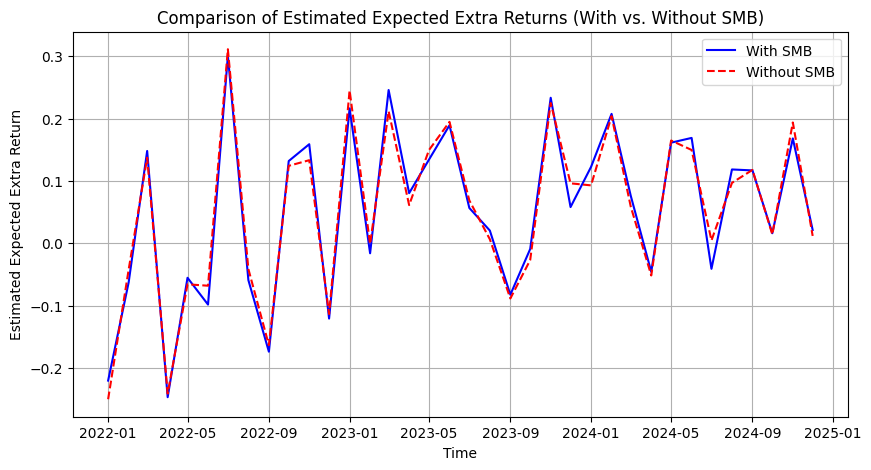

In [ ]:
# Generate the asset expected extra return using the coefficient from the original three-factor model
expected_extra_return = ff3_model.params[0] + ff3_model.params[1] * factor_3_df["MKT"] + ff3_model.params[2] * factor_3_df["SMB"] + ff3_model.params[3] * factor_3_df["HML"]
expected_extra_return.index = expected_extra_return.index.to_timestamp()

# Generate the asset expected extra return using the coefficient from the no SMB model
expected_extra_return_no_smb = ff3_model_no_smb.params[0] + ff3_model_no_smb.params[1] * factor_3_df["MKT"] + ff3_model_no_smb.params[2] * factor_3_df["HML"]
expected_extra_return_no_smb.index = expected_extra_return_no_smb.index.to_timestamp()

# Plot the two expected extra return to compare the effect of removing SMB factor
plt.figure(figsize=(10, 5))
plt.plot(expected_extra_return, label="With SMB", color='blue', linestyle='-')
plt.plot(expected_extra_return_no_smb, label="Without SMB", color='red', linestyle='--')

plt.xlabel("Time")
plt.ylabel("Estimated Expected Extra Return")
plt.title("Comparison of Estimated Expected Extra Returns (With vs. Without SMB)")
plt.legend()
plt.grid(True)

plt.show()

## Compare the asset and benchmark market returns to verify the significance of MKT factor

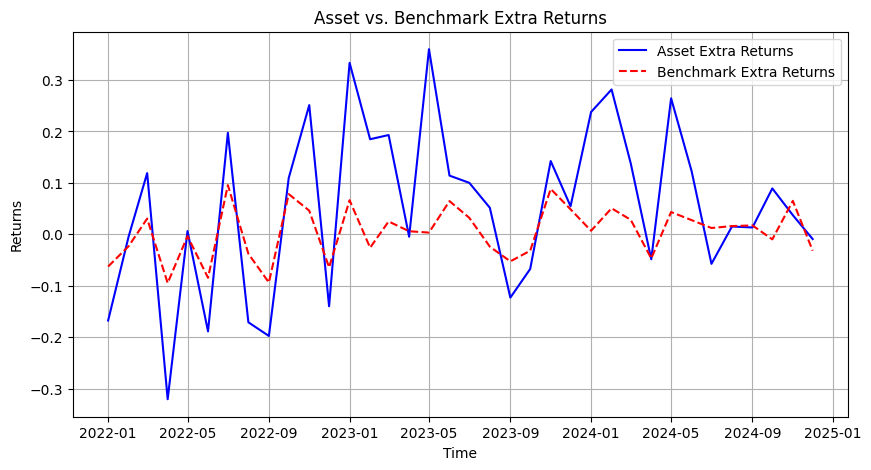

In [ ]:
# Plot the asset and benchmark returns
plt.figure(figsize=(10, 5))
asset_extra_return = factor_3_df["EX_RTN"]
asset_extra_return.index = asset_extra_return.index.to_timestamp()
portf_extra_return = factor_3_df["MKT"]
portf_extra_return.index = portf_extra_return.index.to_timestamp()
plt.plot(asset_extra_return, label="Asset Extra Returns", color='blue', linestyle='-')
plt.plot(portf_extra_return, label="Benchmark Extra Returns", color='red', linestyle='--')

plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Asset vs. Benchmark Extra Returns")
plt.legend()
plt.grid(True)

plt.show()

#  For Single Asset: XOM

In [ ]:
RISKY_ASSET2 = "XOM"

# Download the prices of the risky asset
asset_df2 = yf.download(RISKY_ASSET2, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
# print(asset_df2.shape)
# print(asset_df2.head())

# Calculate the monthly returns on the risky asset
target2 = asset_df2["Close"].resample("M").last().pct_change().dropna()
target2.index = target2.index.to_period("M")
target2.columns = ["RTN"]
# print(target2.head())

# Merge the risky asset with the risk factor dataset and calculate the excess return
factor_3_df2 = factor_3.join(target2)
factor_3_df2["EX_RTN"] = factor_3_df2["RTN"] - factor_3_df2["RF"]
factor_3_df2 = factor_3_df2.dropna()
# print(factor_3_df2.head())

# Estimate the Fama-French 3-factor model
ff3_model2 = smf.ols(formula="EX_RTN ~ MKT + SMB + HML", data=factor_3_df2).fit()
print(ff3_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 EX_RTN   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     14.08
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           5.06e-06
Time:                        22:21:24   Log-Likelihood:                 53.379
No. Observations:                  36   AIC:                            -98.76
Df Residuals:                      32   BIC:                            -92.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0073      0.010      0.730      0.4

<ipython-input-16-81b10566f1e7>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  target2 = asset_df2["Close"].resample("M").last().pct_change().dropna()


#  For Single Asset: MCD

In [ ]:
RISKY_ASSET3 = "MCD"

# Download the prices of the risky asset
asset_df3 = yf.download(RISKY_ASSET3, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
# print(asset_df3.shape)
# print(asset_df3.head())

# Calculate the monthly returns on the risky asset
target3 = asset_df3["Close"].resample("M").last().pct_change().dropna()
target3.index = target3.index.to_period("M")
target3.columns = ["RTN"]
# print(target3.head())

# Merge the risky asset with the risk factor dataset and calculate the excess return
factor_3_df3 = factor_3.join(target3)
factor_3_df3["EX_RTN"] = factor_3_df3["RTN"] - factor_3_df3["RF"]
factor_3_df3 = factor_3_df3.dropna()
#print(factor_3_df3.head())

# Estimate the Fama-French 3-factor model
ff3_model3 = smf.ols(formula="EX_RTN ~ MKT + SMB + HML", data=factor_3_df3).fit()
print(ff3_model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 EX_RTN   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     7.187
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           0.000805
Time:                        22:21:25   Log-Likelihood:                 64.737
No. Observations:                  36   AIC:                            -121.5
Df Residuals:                      32   BIC:                            -115.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0022      0.007     -0.301      0.7

<ipython-input-17-e80cfdcc7555>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  target3 = asset_df3["Close"].resample("M").last().pct_change().dropna()


#  For Single Asset: PFE

In [ ]:
RISKY_ASSET4 = "PFE"

# Download the prices of the risky asset
asset_df4 = yf.download(RISKY_ASSET4, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
# print(asset_df4.shape)
# print(asset_df4.head())

# Calculate the monthly returns on the risky asset
target4 = asset_df4["Close"].resample("M").last().pct_change().dropna()
target4.index = target4.index.to_period("M")
target4.columns = ["RTN"]
# print(target4.head())

# Merge the risky asset with the risk factor dataset and calculate the excess return
factor_3_df4 = factor_3.join(target4)
factor_3_df4["EX_RTN"] = factor_3_df4["RTN"] - factor_3_df4["RF"]
factor_3_df4 = factor_3_df4.dropna()
# print(factor_3_df4.head())

# Estimate the Fama-French 3-factor model
ff3_model4 = smf.ols(formula="EX_RTN ~ MKT + SMB + HML", data=factor_3_df4).fit()
print(ff3_model4.summary())

                            OLS Regression Results                            
Dep. Variable:                 EX_RTN   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.240
Date:                Sat, 01 Mar 2025   Prob (F-statistic):              0.311
Time:                        22:21:25   Log-Likelihood:                 49.933
No. Observations:                  36   AIC:                            -91.87
Df Residuals:                      32   BIC:                            -85.53
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0233      0.011     -2.124      0.0

<ipython-input-18-8ffe4833776e>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  target4 = asset_df4["Close"].resample("M").last().pct_change().dropna()


In [ ]:
# NVDA
# Get the estimated coefficients
coefficients_NVDA = ff3_model.params
# Extract specific coefficients
alpha_NVDA = coefficients_NVDA["Intercept"]  # Alpha (Intercept)
beta_mkt_NVDA = coefficients_NVDA["MKT"]  # Market beta
beta_smb_NVDA = coefficients_NVDA["SMB"]  # SMB beta
beta_hml_NVDA = coefficients_NVDA["HML"]  # HML beta

#XOM
# Get the estimated coefficients
coefficients_XOM = ff3_model2.params
# Extract specific coefficients
alpha_XOM = coefficients_XOM["Intercept"]  # Alpha (Intercept)
beta_mkt_XOM = coefficients_XOM["MKT"]  # Market beta
beta_smb_XOM = coefficients_XOM["SMB"]  # SMB beta
beta_hml_XOM = coefficients_XOM["HML"]  # HML beta

# MCD
# Get the estimated coefficients
coefficients_MCD = ff3_model3.params
# Extract specific coefficients
alpha_MCD = coefficients_MCD["Intercept"]  # Alpha (Intercept)
beta_mkt_MCD = coefficients_MCD["MKT"]  # Market beta
beta_smb_MCD = coefficients_MCD["SMB"]  # SMB beta
beta_hml_MCD = coefficients_MCD["HML"]  # HML beta

#PFE
# Get the estimated coefficients
coefficients_PFE = ff3_model4.params
# Extract specific coefficients
alpha_PFE = coefficients_PFE["Intercept"]  # Alpha (Intercept)
beta_mkt_PFE = coefficients_PFE["MKT"]  # Market beta
beta_smb_PFE = coefficients_PFE["SMB"]  # SMB beta
beta_hml_PFE = coefficients_PFE["HML"]  # HML beta

# Expected portfolio return
# alpha
alpha = np.array([alpha_NVDA, alpha_XOM, alpha_MCD, alpha_PFE])
print("alpha: ", alpha)

# B matrix
B = np.array([[beta_mkt_NVDA, beta_mkt_XOM, beta_mkt_MCD, beta_mkt_PFE],
                   [beta_smb_NVDA, beta_smb_XOM, beta_smb_MCD, beta_smb_PFE],
                   [beta_hml_NVDA, beta_hml_XOM, beta_hml_MCD, beta_hml_PFE]])
print("B: ", B)

alpha:  [ 0.04324043  0.00727562 -0.00218716 -0.02327486]
B:  [[ 2.37558413  0.74076035  0.66905781  0.4158074 ]
 [-0.6558412  -0.7488925  -0.12229997 -0.25374978]
 [-1.2023976   1.25914644  0.20454877  0.18833944]]


In [ ]:
# Test
w = [0.4, 0.3, 0.2, 0.1]
alpha = alpha@w
print(alpha)
beta = B@w
print(beta)

0.016713939089223487
[ 1.34785406 -0.5368392  -0.04347141]


# Expected Portfolio Return

In [ ]:
# Define B matrix (4 assets x 3 factors)
B = np.array([
    [ff3_model.params["MKT"], ff3_model2.params["MKT"], ff3_model3.params["MKT"], ff3_model4.params["MKT"]],
    [ff3_model.params["SMB"], ff3_model2.params["SMB"], ff3_model3.params["SMB"], ff3_model4.params["SMB"]],
    [ff3_model.params["HML"], ff3_model2.params["HML"], ff3_model3.params["HML"], ff3_model4.params["HML"]],
]).T  # Shape: (4, 3)

# Define alpha vector (4×1)
alpha = np.array([
    ff3_model.params["Intercept"],
    ff3_model2.params["Intercept"],
    ff3_model3.params["Intercept"],
    ff3_model4.params["Intercept"]
]).reshape(4, 1)  # Shape: (4, 1)

# Compute expected factor returns (mean returns of MKT, SMB, HML) (3×1)
# since expected return, we take the mean
f = factor_3_df[["MKT", "SMB", "HML"]].mean().values.reshape(3, 1)  # Shape: (3, 1)

# Compute expected asset returns (alpha + B f)
expected_asset_returns = alpha + B@f  # Shape: (4, 1)

print("alpha:\n", alpha)
print("B:\n", B)
print("f:\n", f)
print("Expected Asset Returns:\n", expected_asset_returns)

alpha:
 [[ 0.04324043]
 [ 0.00727562]
 [-0.00218716]
 [-0.02327486]]
B:
 [[ 2.37558413 -0.6558412  -1.2023976 ]
 [ 0.74076035 -0.7488925   1.25914644]
 [ 0.66905781 -0.12229997  0.20454877]
 [ 0.4158074  -0.25374978  0.18833944]]
f:
 [[ 0.00468056]
 [-0.00458889]
 [ 0.00335833]]
Expected Asset Returns:
 [[ 0.05333102]
 [ 0.018408  ]
 [ 0.00219256]
 [-0.01953171]]


In [ ]:
# Define portfolio weights (4×1)
w = np.array([0.4, 0.3, 0.2, 0.1]).T

# Compute expected portfolio return
expected_portfolio_return = expected_asset_returns.T@w  # Scalar

print("alpha*w:", alpha.T@w)
print("B*w:", B.T@w)
print("Expected Portfolio Return:", expected_portfolio_return)

alpha*w: [0.01671394]
B*w: [ 1.34785406 -0.5368392  -0.04347141]
Expected Portfolio Return: [0.02534015]


# Variance of the portfolio return

In [ ]:
# Define B matrix (4 assets x 3 factors)
B = np.array([
    [ff3_model.params["MKT"], ff3_model2.params["MKT"], ff3_model3.params["MKT"], ff3_model4.params["MKT"]],
    [ff3_model.params["SMB"], ff3_model2.params["SMB"], ff3_model3.params["SMB"], ff3_model4.params["SMB"]],
    [ff3_model.params["HML"], ff3_model2.params["HML"], ff3_model3.params["HML"], ff3_model4.params["HML"]],
]).T  # Shape: (4, 3)

# Compute factor covariance matrix (Q_f) (3×3)
Q_f = factor_3_df[["MKT", "SMB", "HML"]].cov().values  # Shape: (3, 3)

# Compute residual variances (4×4)
D = np.diag([
    np.var(ff3_model.resid, ddof=1),
    np.var(ff3_model2.resid, ddof=1),
    np.var(ff3_model3.resid, ddof=1),
    np.var(ff3_model4.resid, ddof=1)
])  # Shape: (4, 4)

# Define portfolio weights (4×1 vector)
w = np.array([0.4, 0.3, 0.2, 0.1]).reshape(4, 1)

# Compute systematic covariance matrix (B Q_f B^T)
systematic_cov_matrix = B @ Q_f @ B.T  # Shape: (4, 4)

# Compute total covariance matrix (Q)
Q = systematic_cov_matrix + D  # Shape: (4, 4)

# Compute portfolio variance
portfolio_variance = w.T @ Q @ w  # Scalar

print("Systematic Variance Matrix (B Q_f B^T):\n", systematic_cov_matrix)
print("Error terms Variance Matrix (D):\n", D)
print("Total Portfolio Variance:", portfolio_variance[0][0])


Systematic Variance Matrix (B Q_f B^T):
 [[0.01832263 0.00027053 0.00348565 0.00187537]
 [0.00027053 0.00409635 0.00131906 0.00102876]
 [0.00348565 0.00131906 0.00111264 0.00066542]
 [0.00187537 0.00102876 0.00066542 0.00043686]]
Error terms Variance Matrix (D):
 [[0.00784837 0.         0.         0.        ]
 [0.         0.00310364 0.         0.        ]
 [0.         0.         0.00165129 0.        ]
 [0.         0.         0.         0.00375835]]
Total Portfolio Variance: 0.006007157297746567


# Mean-variance portfolio optimization model

# For Portfolio consisting of 4 Assets: NVDA, XOM, MCD and PFE

1.   Specify the portfolio and weights

In [ ]:
ASSETS = ["NVDA", "XOM", "MCD", "PFE"]
WEIGHTS = [0.4, 0.3, 0.2, 0.1]

2. Download the prices of the assets in the portfolio

In [ ]:
portf_df = yf.download(ASSETS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
print(portf_df.shape)
print(portf_df.head())

(753, 20)
Price            Close                                         High  \
Ticker             MCD       NVDA        PFE        XOM         MCD   
Date                                                                  
2021-12-31  250.326721  29.362165  50.720104  54.546890  251.307211   
2022-01-03  250.802963  30.070992  48.658661  56.641758  252.810680   
2022-01-04  250.737625  29.241371  46.837727  58.772289  253.202872   
2022-01-05  249.504990  27.558170  47.782543  59.503265  252.390462   
2022-01-06  251.839493  28.131214  47.103992  60.902813  252.838677   

Price                                               Low                        \
Ticker           NVDA        PFE        XOM         MCD       NVDA        PFE   
Date                                                                            
2021-12-31  29.980139  51.364305  54.796494  249.523629  29.282298  50.196153   
2022-01-03  30.660012  50.290635  56.695242  247.982864  29.735549  48.392390   
2022-01-04  30.4

3.   Calculate the monthly returns of each assets in the portfolio

In [ ]:
portf_df = portf_df["Close"].resample("ME").last().pct_change().dropna()
portf_df.index = portf_df.index.to_period("M")
portf_df = portf_df[ASSETS]
print(portf_df.head())

Ticker       NVDA       XOM       MCD       PFE
Date                                           
2022-01 -0.167454  0.241379 -0.032156 -0.100921
2022-02 -0.004125  0.043831 -0.051333 -0.109129
2022-03  0.119157  0.053175  0.010255  0.102897
2022-04 -0.320274  0.032207  0.007603 -0.052154
2022-05  0.006740  0.137635  0.012241  0.089720


4.   Calculate the portfolio return

In [ ]:
portf_df["PORTF_RTN"] = np.matmul(portf_df[ASSETS].values, WEIGHTS)
print(portf_df.head())

Ticker       NVDA       XOM       MCD       PFE  PORTF_RTN
Date                                                      
2022-01 -0.167454  0.241379 -0.032156 -0.100921  -0.011091
2022-02 -0.004125  0.043831 -0.051333 -0.109129  -0.009680
2022-03  0.119157  0.053175  0.010255  0.102897   0.075956
2022-04 -0.320274  0.032207  0.007603 -0.052154  -0.122142
2022-05  0.006740  0.137635  0.012241  0.089720   0.055407


5.   Merge the portfolio with the risk factor dataset and calculate the excess return

In [ ]:
factor_3_portf_df = factor_3.join(portf_df["PORTF_RTN"])
factor_3_portf_df["EX_PORTF_RTN"] = factor_3_portf_df["PORTF_RTN"] - factor_3_portf_df["RF"]
factor_3_portf_df = factor_3_portf_df.dropna()
print(factor_3_portf_df.head())

            MKT     SMB     HML      RF  PORTF_RTN  EX_PORTF_RTN
Date                                                            
2022-01 -0.0625 -0.0596  0.1280  0.0000  -0.011091     -0.011091
2022-02 -0.0229  0.0219  0.0310  0.0000  -0.009680     -0.009680
2022-03  0.0306 -0.0166 -0.0176  0.0001   0.075956      0.075856
2022-04 -0.0946 -0.0138  0.0617  0.0001  -0.122142     -0.122242
2022-05 -0.0034 -0.0196  0.0859  0.0003   0.055407      0.055107


6.   Estimate the Fama-French 3-factor model for the portfolio

In [ ]:
ff3_model_portf = smf.ols(formula="EX_PORTF_RTN ~ MKT + SMB + HML", data=factor_3_portf_df).fit()
print(ff3_model_portf.summary())

                            OLS Regression Results                            
Dep. Variable:           EX_PORTF_RTN   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     34.49
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           3.82e-10
Time:                        22:21:45   Log-Likelihood:                 68.352
No. Observations:                  36   AIC:                            -128.7
Df Residuals:                      32   BIC:                            -122.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0167      0.007      2.544      0.0

## Correlation among three factors

In [ ]:
# Generate the correlation among three factors (for the portfolio of four assets)
corr_matrix_portf = factor_3_portf_df[["MKT", "SMB", "HML"]].corr()
print(corr_matrix_portf)

          MKT       SMB       HML
MKT  1.000000  0.314943 -0.128554
SMB  0.314943  1.000000  0.002565
HML -0.128554  0.002565  1.000000


## Re-run the model without the HML factor (i.e. after dropping HML factor considering this p-value)

In [ ]:
ff3_model_portf_no_smb = smf.ols(formula="EX_PORTF_RTN ~ MKT + SMB", data=factor_3_portf_df).fit()
print(ff3_model_portf_no_smb.summary())

                            OLS Regression Results                            
Dep. Variable:           EX_PORTF_RTN   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     53.16
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           4.77e-11
Time:                        22:21:45   Log-Likelihood:                 68.302
No. Observations:                  36   AIC:                            -130.6
Df Residuals:                      33   BIC:                            -125.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0165      0.006      2.562      0.0

<ipython-input-32-2bc43b7dc99a>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_extra_return_portf = ff3_model_portf.params[0] + ff3_model_portf.params[1] * factor_3_portf_df["MKT"] + ff3_model_portf.params[2] * factor_3_portf_df["SMB"] + ff3_model_portf.params[3] * factor_3_portf_df["HML"]
<ipython-input-32-2bc43b7dc99a>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_extra_return_portf_no_smb = ff3_model_portf_no_smb.params[0] + ff3_model_portf_no_smb.params[1] * factor_3_portf_df["MKT"] + ff3_model_portf_no_smb.params[2] * factor_3_portf_df["SMB"]


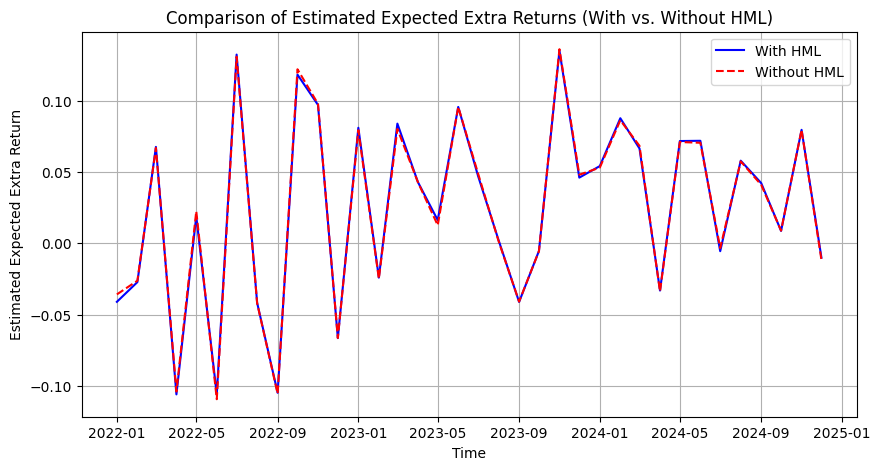

In [ ]:
# Generate the portfolio expected extra return using the coefficient from the original three-factor model
expected_extra_return_portf = ff3_model_portf.params[0] + ff3_model_portf.params[1] * factor_3_portf_df["MKT"] + ff3_model_portf.params[2] * factor_3_portf_df["SMB"] + ff3_model_portf.params[3] * factor_3_portf_df["HML"]
expected_extra_return_portf.index = expected_extra_return_portf.index.to_timestamp()

# Generate the portfolio expected extra return using the coefficient from the no HML model
expected_extra_return_portf_no_smb = ff3_model_portf_no_smb.params[0] + ff3_model_portf_no_smb.params[1] * factor_3_portf_df["MKT"] + ff3_model_portf_no_smb.params[2] * factor_3_portf_df["SMB"]
expected_extra_return_portf_no_smb.index = expected_extra_return_portf_no_smb.index.to_timestamp()

# Plot the two expected extra return to compare the effect of removing SMB factor
plt.figure(figsize=(10, 5))
plt.plot(expected_extra_return_portf, label="With HML", color='blue', linestyle='-')
plt.plot(expected_extra_return_portf_no_smb, label="Without HML", color='red', linestyle='--')

plt.xlabel("Time")
plt.ylabel("Estimated Expected Extra Return")
plt.title("Comparison of Estimated Expected Extra Returns (With vs. Without HML)")
plt.legend()
plt.grid(True)

plt.show()

# Estimating the rolling three-factor model on a portfolio of assets

1.   Specify the rolling time-line

In [ ]:
START_DATE_ROLL = "2013-12-31"
END_DATE_ROLL = "2024-12-31"

2.   Download the dataset containing the risk factors

In [ ]:
factor_3_roll = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=START_DATE_ROLL, end=END_DATE_ROLL)[0].rename(columns={"Mkt-RF": "MKT"}).div(100)

<ipython-input-34-32040e020850>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_3_roll = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=START_DATE_ROLL, end=END_DATE_ROLL)[0].rename(columns={"Mkt-RF": "MKT"}).div(100)
<ipython-input-34-32040e020850>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_3_roll = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=START_DATE_ROLL, end=END_DATE_ROLL)[0].rename(columns={"Mkt-RF": "MKT"}).div(100)


3.   Download the prices of the portfolio

In [ ]:
portf_df_roll = yf.download(ASSETS, start=START_DATE_ROLL, end=END_DATE_ROLL, auto_adjust=True, progress=False)
print(portf_df_roll.shape)
print(portf_df_roll.head())

(2768, 20)
Price           Close                                       High            \
Ticker            MCD      NVDA        PFE        XOM        MCD      NVDA   
Date                                                                         
2013-12-31  72.733803  0.377739  18.619505  63.087124  72.771285  0.379625   
2014-01-02  72.269058  0.373966  18.516176  62.183228  72.733807  0.376796   
2014-01-03  72.366486  0.369486  18.552643  62.033630  72.733789  0.375381   
2014-01-06  71.849251  0.374438  18.570881  62.127117  72.426447  0.377267   
2014-01-07  72.246552  0.380568  18.686377  63.006096  72.771276  0.381983   

Price                                   Low                                  \
Ticker            PFE        XOM        MCD      NVDA        PFE        XOM   
Date                                                                          
2013-12-31  18.728924  63.205570  72.433961  0.374909  18.534402  62.607115   
2014-01-02  18.601279  62.812854  72.156617  0.3

4.   Calculate the monthly returns on the portfolio

In [ ]:
portf_df_roll = portf_df_roll["Close"].resample("M").last().pct_change().dropna()
portf_df_roll.index = portf_df_roll.index.to_period("M")
portf_df_roll = portf_df_roll[ASSETS]
print(portf_df_roll.head())

Ticker       NVDA       XOM       MCD       PFE
Date                                           
2014-01 -0.019975 -0.089327 -0.029476 -0.007509
2014-02  0.175987  0.051995  0.019014  0.065057
2014-03 -0.025571  0.014646  0.030268  0.000312
2014-04  0.031267  0.048424  0.034173 -0.026153
2014-05  0.033433 -0.011693  0.008558 -0.044306


<ipython-input-36-494e171dc6d3>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  portf_df_roll = portf_df_roll["Close"].resample("M").last().pct_change().dropna()


5.   Calculate the portfolio returns

In [ ]:
portf_df_roll["PORTF_RTN"] = np.matmul(portf_df_roll[ASSETS].values, WEIGHTS)
print(portf_df_roll.head())

Ticker       NVDA       XOM       MCD       PFE  PORTF_RTN
Date                                                      
2014-01 -0.019975 -0.089327 -0.029476 -0.007509  -0.041434
2014-02  0.175987  0.051995  0.019014  0.065057   0.096302
2014-03 -0.025571  0.014646  0.030268  0.000312   0.000250
2014-04  0.031267  0.048424  0.034173 -0.026153   0.031253
2014-05  0.033433 -0.011693  0.008558 -0.044306   0.007146


6.   Merge the portfolio with the risk factor dataset and calculate the excess return

In [ ]:
factor_3_roll_df = factor_3_roll.join(portf_df_roll["PORTF_RTN"])
factor_3_roll_df["EX_PORTF_RTN"] = factor_3_roll_df["PORTF_RTN"] - factor_3_roll_df["RF"]
factor_3_roll_df = factor_3_roll_df.dropna()
print(factor_3_roll_df.head())

            MKT     SMB     HML   RF  PORTF_RTN  EX_PORTF_RTN
Date                                                         
2014-01 -0.0332  0.0089 -0.0207  0.0  -0.041434     -0.041434
2014-02  0.0465  0.0034 -0.0031  0.0   0.096302      0.096302
2014-03  0.0043 -0.0181  0.0493  0.0   0.000250      0.000250
2014-04 -0.0019 -0.0418  0.0117  0.0   0.031253      0.031253
2014-05  0.0206 -0.0188 -0.0013  0.0   0.007146      0.007146


7.   Define the rolling function

In [ ]:
def rolling_ff3(input_data, formula, window_size):

  """
  Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.

  Parameters
  ------------
  input_data : pd.DataFrame
      A DataFrame containing the factors and asset/portfolio returns
  formula : str
      `statsmodels` compatible formula representing the OLS regression
  window_size : int
      Rolling window length.

  Returns
  -----------
  coeffs_df : pd.DataFrame
      DataFrame containing the intercept and the three factors for each iteration.
  """

  coeffs = []

  for start_ind in range(len(input_data) - window_size + 1):
    end_ind = start_ind + window_size

    # define and fit the regression model
    ff_model = smf.ols(
        formula=formula,
        data=input_data[start_ind:end_ind]
        ).fit()

    # store coefficients
    coeffs.append(ff_model.params)

  coeffs_df = pd.DataFrame(
      coeffs,
      index=input_data.index[window_size - 1:]
      )

  return coeffs_df

8.   Estimate the rolling three-factor model and plot the results

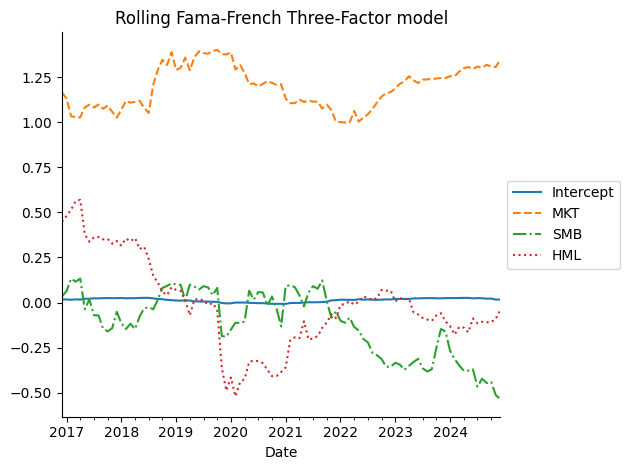

In [ ]:
MODEL_FORMULA = "EX_PORTF_RTN ~ MKT + SMB + HML"
results_df = rolling_ff3(factor_3_roll_df, MODEL_FORMULA, window_size=36)
(
    results_df
    .plot(title = "Rolling Fama-French Three-Factor model",
          style=["-", "--", "-.", ":"])
    .legend(loc="center left",bbox_to_anchor=(1.0, 0.5))
)

sns.despine()
plt.tight_layout()
# plt.savefig("Rolling_FF3M.png", dpi=200)

#HML = 1/2(Small Value + Big Value) - 1/2 (Small Growth + Big Growth)



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 6_Portfolios_2x3.CSV to 6_Portfolios_2x3.CSV


In [ ]:
file_path = '/content/6_Portfolios_2x3.CSV'
df_risk = pd.read_csv(file_path, skiprows=15, nrows=1183, index_col=0)
print(df_risk.head())

        SMALL LoBM  ME1 BM2  SMALL HiBM  BIG LoBM  ME2 BM2  BIG HiBM
192607      1.0874   0.9081     -0.0695    5.7168   1.8971    2.0066
192608      0.7030   1.5075      5.3842    2.7154   2.7196    5.6796
192609     -2.9117  -0.1359     -0.4374    1.4287   0.0808   -0.7928
192610     -3.8196  -4.3572     -2.0112   -3.5898  -2.3377   -3.9998
192611      3.1806   3.6608      2.0944    3.1292   2.9242    3.1934


In [ ]:
# Convert relevant columns to numeric
df_risk['SMALL HiBM'] = pd.to_numeric(df_risk['SMALL HiBM'], errors='coerce')
df_risk['BIG HiBM'] = pd.to_numeric(df_risk['BIG HiBM'], errors='coerce')
df_risk['SMALL LoBM'] = pd.to_numeric(df_risk['SMALL LoBM'], errors='coerce')
df_risk['BIG LoBM'] = pd.to_numeric(df_risk['BIG LoBM'], errors='coerce')
df_risk['ME1 BM2'] = pd.to_numeric(df_risk['ME1 BM2'], errors='coerce')
df_risk['ME2 BM2'] = pd.to_numeric(df_risk['ME2 BM2'], errors='coerce')
print(df_risk.dtypes)

SMALL LoBM    float64
ME1 BM2       float64
SMALL HiBM    float64
BIG LoBM      float64
ME2 BM2       float64
BIG HiBM      float64
dtype: object


In [ ]:
df_risk['HML'] = (df_risk['SMALL HiBM'] + df_risk['BIG HiBM'])/2 - (df_risk['SMALL LoBM'] + df_risk['BIG LoBM'])/2
df_risk.head()

,SMALL LoBM,ME1 BM2,SMALL HiBM,BIG LoBM,ME2 BM2,BIG HiBM,HML
192607,1.0874,0.9081,-0.0695,5.7168,1.8971,2.0066,-2.43355
192608,0.7030,1.5075,5.3842,2.7154,2.7196,5.6796,3.82270
192609,-2.9117,-0.1359,-0.4374,1.4287,0.0808,-0.7928,0.12640
192610,-3.8196,-4.3572,-2.0112,-3.5898,-2.3377,-3.9998,0.69920
192611,3.1806,3.6608,2.0944,3.1292,2.9242,3.1934,-0.51100


In [ ]:
df_risk.loc['202112':'202204']['HML']/100

,HML
202112,0.032202
202201,0.127971
202202,0.030975
202203,-0.017641
202204,0.061656


#SMB =1/3 (Small Value + Small Neutral + Small Growth) - 1/3 (Big Value + Big Neutral + Big Growth)



In [ ]:
df_risk['SMB'] = (1/3)*(df_risk['SMALL HiBM'] + df_risk['ME1 BM2'] + df_risk['SMALL LoBM']) - (1/3)*(df_risk['BIG HiBM'] + df_risk['ME2 BM2'] + df_risk['BIG LoBM'])
df_risk.loc['202112':'202204']['SMB']/100

,SMB
202112,-0.016404
202201,-0.059643
202202,0.021886
202203,-0.016590
202204,-0.013848
